In [1]:
import sys
import os
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import scipy.io
from idtxl.data import Data
from idtxl.bivariate_te import BivariateTE
from idtxl.bivariate_te import BivariateTE
import warnings
import multiprocessing as mp
import time
import logging

# Bivariate TE

This function (```bivar_pair```) is used for a "single" bivariate pair calculation between a given source and target time series

In [2]:
def bivar_pair(source, target, 
                min_lag_src, max_lag_src, 
            #    min_lag_tgt, max_lag_tgt, # why is there no min_lag_tgt? am i dumb?
                max_lag_tgt,
                n_perm=100, verbose=False, ckp=False):
    
    with warnings.catch_warnings():
        # Supress the stupid fluff that IDTxl prints
        warnings.filterwarnings('ignore', category=UserWarning, message="Number of replications is not sufficient")
    
    n = np.size(source)
    if n != np.size(target):
        print("Error: source and target must have the same number of samples.")
        return np.nan, np.nan
    
    # Reshape to (n, 1)
    source_reshaped = source.reshape(-1, 1)
    target_reshaped = target.reshape(-1, 1)
    
    # Pearson correlation
    corr = np.corrcoef(source_reshaped[:, 0], target_reshaped[:, 0])[0, 1]
    
    # Data preparation for IDTxl
    # Data stacked as (samples, processes)
    data_idt = Data(np.hstack((source_reshaped, target_reshaped)),
                dim_order='sp',  # samples, processes
                normalise=True) # Normalization?
    
    # TE settings
    settings = {
        'cmi_estimator': 'JidtKraskovCMI',
        'n_perm_max_stat': n_perm,  # Number of permutations for significance testing (max_stat part)
        'n_perm_min_stat': n_perm,  # 
        'n_perm_max_seq': n_perm,   # 
        'n_perm_omnibus': n_perm,   # 
        'max_lag_sources': max_lag_src,
        'min_lag_sources': min_lag_src,
        'max_lag_target': max_lag_tgt,
        'verbose': verbose,
        'write_ckp': ckp,
        # 'reuse_missing_data_ests': True, # Consider if you have missing data
        'alpha_max_stat': 0.05, # Significance level for max_stat test
        'alpha_min_stat': 0.05, # Significance level for min_stat test
        'alpha_max_seq': 0.05,  # Significance level for max_seq test
        'alpha_omnibus': 0.05,  # Significance level for omnibus test
        'fdr_correction': False # Set to True if you want FDR correction on p-values
    }
    
    # TE computation
    try:
        bte = BivariateTE()
        # For bivariate TE with data [source, target]
        # source is process 0, target is process 1
        results_bte = bte.analyse_single_target(
            settings=settings,
            data=data_idt,
            target=1,
            sources=[0]
        )
        
        # Get the TE result for the target (index 1)
        # fdr=False means we are not applying False Discovery Rate correction here
        # to filter results based on p-values. We get the raw calculation.
        single_process_obj = results_bte.get_single_target(target_id=1, fdr=False)
        
        if single_process_obj is not None and hasattr(single_process_obj, 'omnibus_te'):
            te_value = single_process_obj.omnibus_te
            # p_value = single_process_te_obj.p_value_omnibus_te
            # print(f"  TE value: {te_value:.4f}, p-value: {p_value if p_value is not None else 'N/A'}")
            return te_value, corr
        else:
            # This case might occur if no significant interaction is found or an issue arises
            print(f"No significant TE found or result object is None. source: {source_reshaped}, target: {target_reshaped}")
    
    except Exception as e:
        print(f"Error during TE computation: {e}")
        return np.nan, corr

And this function (```te_study```) is a helper used to run the TE calculations for the given number of POD modes.

In [ ]:
## Settings
data_dir = "/"

# Number of POD modes
# Mode 0 is the mean, so we should not include it in the analysis.
# For this script, we assume 1-indexed modes from tmcoeff 
# (as in, tmcoeff[:, 0] is the mean mode, so we start from 1).
NUM_POD = 20

# Lag parameters
min_lag_s = 1
max_lag_s = 50
max_lag_t = 50

# Verbosity and checkpointing
verbose = False
ckp = False

# Placeholders for mp
mp_tmcoeff = None
mp_bivar_func = None

# Parallel processing setup
num_proc = mp.cpu_count() - 1

In [4]:
def te_worker(args_tuple):
    target_idx, source_idx, min_l_s, max_l_s, max_l_t, verbose_worker, checkpoints_worker = args_tuple
    
    if mp_tmcoeff is None or mp_bivar_func is None:
        raise RuntimeError("Global data/function for worker not initialized.")
    
    source_ts = mp_tmcoeff[:, source_idx]
    target_ts = mp_tmcoeff[:, target_idx]
    
    te_val, corr_val = bivar_pair(
        source=source_ts,
        target=target_ts,
        min_lag_src=min_lag_s,
        max_lag_src=max_lag_s,
        max_lag_tgt=max_lag_t,
        n_perm=100,  # Number of permutations for significance testing
        verbose=verbose,
        ckp=ckp
    )
    
    return target_idx, source_idx, te_val, corr_val

def te_study_parallel():
    global mp_tmcoeff, mp_bivar_func
    
    ## Load data
    try:
        data = scipy.io.loadmat(os.path.join(data_dir, 'A2coef.mat'))
        tmcoeff_full = data['A2']   # Expected shape: (n_samples, n_modes)
    except Exception as e:
        print(f"Error loading data: {e}")
        return
    
    num_modes = tmcoeff_full.shape[1]
    actual_modes = min(num_modes, NUM_POD)
    
    if actual_modes < 2:
        print("Error: Something went wrong with the data loading. Less than 2 POD modes found.")
        return None, None, actual_modes
    
    print(f"Found {num_modes} POD modes, using {actual_modes} modes for analysis.")
    mp_tmcoeff = tmcoeff_full[:, 1:actual_modes+1] # We exclude the mean mode (mode 0) here
    mp_bivar_func = bivar_pair
    
    tasks = []
    for source_idx in range(actual_modes):
        for target_idx in range(actual_modes):
            if target_idx == source_idx:
                continue # Skip TE from a mode to itself
            task_args = (
                target_idx, source_idx,
                min_lag_s, max_lag_s, max_lag_t,
                verbose, ckp
            )
            tasks.append(task_args)
            
    if not tasks:
        print("No tasks to process (e.g., only 1 mode selected).")
        # Still initialize matrices in case
        te_matrix = np.full((actual_modes, actual_modes), 0.0 if actual_modes > 0 else np.nan)
        corr_matrix = np.full((actual_modes, actual_modes), 1.0 if actual_modes > 0 else np.nan)
        if actual_modes == 1: # Fill diagonal for single mode case
             te_matrix[0,0] = 0.0
             corr_matrix[0,0] = 1.0
        return te_matrix, corr_matrix
    
    print(f"\nStarting Bivariate Transfer Entropy calculations for {len(tasks)} pairs using {num_proc} processes...")
    start_time = time.time()

    chunksize = 1 # Maybe increase later if cpu utilization is low
    
    results_list = []
    with mp.Pool(processes=num_proc) as pool:
        async_result = pool.map_async(te_worker, tasks, chunksize=chunksize)
        
        # Progress tracking
        total_tasks = len(tasks)
        # Estimate number of tasks per chunk (can be off)
        num_tasks_chunk = (total_tasks + chunksize -1) // chunksize 
        
        while not async_result.ready():
            # _number_left refers to chunks, not individual tasks, if chunksize > 1
            num_left = async_result._number_left
            completed = num_tasks_chunk - num_left
            
            percent = int((completed / num_tasks_chunk) * 100) if num_tasks_chunk > 0 else 0
            
            print(f"Progress: {percent}% (approx. {completed}/{num_tasks_chunk} chunks processed)      ", end='\r', flush=True)
            time.sleep(1) # Check every second
            
    print(f"Progress: 100% ({total_tasks}/{total_tasks} pairs processed)                      ")
    print(f"Parallel calculations finished. Time taken: {time.time() - start_time:.2f} seconds")
    
    # Assemble results into matrices
    te_matrix_bivar = np.full((actual_modes, actual_modes), np.nan)
    corr_matrix = np.full((actual_modes, actual_modes), np.nan)

    # Fill diagonal for self-loops (TE=0, Corr=1)
    for i in range(actual_modes):
        te_matrix_bivar[i, i] = 0.0
        corr_matrix[i, i] = 1.0
        
    for res_target_idx, res_source_idx, te_val, corr_val in results_list:
        te_matrix_bivar[res_target_idx, res_source_idx] = te_val
        corr_matrix[res_target_idx, res_source_idx] = corr_val
        
    return te_matrix_bivar, corr_matrix, actual_modes

In [5]:
te_matrix_bivar, corr_matrix, num_modes = te_study_parallel()

Found 1800 POD modes, using 20 modes for analysis.

Starting Bivariate Transfer Entropy calculations for 380 pairs using 15 processes...
Adding data with properties: 2 processes, 1800 samples, 1 replicationsAdding data with properties: 2 processes, 1800 samples, 1 replicationsAdding data with properties: 2 processes, 1800 samples, 1 replicationsAdding data with properties: 2 processes, 1800 samples, 1 replicationsAdding data with properties: 2 processes, 1800 samples, 1 replicationsAdding data with properties: 2 processes, 1800 samples, 1 replicationsAdding data with properties: 2 processes, 1800 samples, 1 replicationsAdding data with properties: 2 processes, 1800 samples, 1 replicationsAdding data with properties: 2 processes, 1800 samples, 1 replicationsAdding data with properties: 2 processes, 1800 samples, 1 replications

Adding data with properties: 2 processes, 1800 samples, 1 replicationsAdding data with properties: 2 processes, 1800 samples, 1 replications
Adding data with pro

Process ForkPoolWorker-6:
Process ForkPoolWorker-3:
Process ForkPoolWorker-10:
Process ForkPoolWorker-14:
Process ForkPoolWorker-13:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-4:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/kris/.local/share/uv/python/cpython-3.11.12-linux-x86_64-gnu/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Process ForkPoolWorker-9:
  File "/home/kris/.local/share/uv/python/cpython-3.11.12-linux-x86_64-gnu/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
Process ForkPoolWorker-8:
  File "/home/kris/.local/share/uv/python/cpython-3.11.12-linux-x86_64-gnu/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/kris/.local/share/uv/python/cpython-3.11.12-linux-x86_64-gnu/lib/

KeyboardInterrupt: 

In [ ]:
print("\n--- Bivariate Transfer Entropy Matrix (Source -> Target) ---")
print(np.around(te_matrix_bivar, decimals=4))
print("\n--- Pearson Correlation Matrix (Xt, Yt) ---")
print(np.around(corr_matrix, decimals=4))

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im_te = axes[0].imshow(te_matrix_bivar, cmap='viridis', origin='lower')
axes[0].set_title(f'Bivariate TE (Source -> Target)\nMax TE: {np.nanmax(te_matrix_bivar):.3f}')
axes[0].set_xlabel('Source Mode Index')
axes[0].set_ylabel('Target Mode Index')
ticks = np.arange(actual_modes)
axes[0].set_xticks(ticks)
axes[0].set_yticks(ticks)
fig.colorbar(im_te, ax=axes[0], label='TE Value')

im_corr = axes[1].imshow(corr_matrix, cmap='coolwarm', origin='lower', vmin=-1, vmax=1)
axes[1].set_title('Pearson Correlation (Xt, Yt)')
axes[1].set_xlabel('Source Mode Index')
axes[1].set_ylabel('Target Mode Index')
axes[1].set_xticks(ticks)
axes[1].set_yticks(ticks)
fig.colorbar(im_corr, ax=axes[1], label='Correlation')

plt.tight_layout()
plt.show()

In [ ]:
def te_study():
    # Should this even be a function? idk... myabe rewrite this later.
    
    ## Load data
    try:
        data = scipy.io.loadmat(os.path.join(data_dir, 'A2coef.mat'))
        tmcoeff_full = data['A2']   # Expected shape: (n_samples, n_modes)
    except Exception as e:
        print(f"Error loading data: {e}")
        return
    
    num_modes = tmcoeff_full.shape[1]
    actual_modes = min(num_modes, NUM_POD)
    
    if actual_modes < 2:
        print("Error: Something went wrong with the data loading. Less than 2 POD modes found.")
        return None, None, actual_modes
    
    print(f"Found {num_modes} POD modes, using {actual_modes} modes for analysis.")
    tmcoeff = tmcoeff_full[:, 1:actual_modes+1] # We exclude the mean mode (mode 0) here
    
    ## TE matrix calculation
    # TE_matrix[i, j] will store TE from mode j to mode i
    te_matrix_bivar = np.full((actual_modes, actual_modes), np.nan)
    corr_matrix = np.full((actual_modes, actual_modes), np.nan)
    
    print(f"\nStarting Bivariate Transfer Entropy calculations for {actual_modes} POD modes...")
    for source_idx in range(actual_modes):
        for target_idx in range(actual_modes):
            if target_idx == source_idx:
                te_matrix_bivar[target_idx, source_idx] = 0.0 # or np.nan?
                corr_matrix[target_idx, source_idx] = 1.0 # let's assume perfect correlation with itself, otherwise we need jesus
                continue
            
            print(f"Calculating TE: Mode {source_idx} -> Mode {target_idx}...")
            
            source_ts = tmcoeff[:, source_idx]
            target_ts = tmcoeff[:, target_idx]
            
            te_val, corr_val = bivar_pair(
                source=source_ts,
                target=target_ts,
                min_lag_src=min_lag_s,
                max_lag_src=max_lag_s,
                max_lag_tgt=max_lag_t,
                n_perm=100,  # Number of permutations for significance testing
                verbose=verbose,
                ckp=ckp
            )
            
            te_matrix_bivar[target_idx, source_idx] = te_val
            corr_matrix[target_idx, source_idx] = corr_val
            
    return te_matrix_bivar, corr_matrix, actual_modes

Now we run and plot

In [30]:
te_matrix_bivar, corr_matrix, actual_modes = te_study()

Number of POD modes found: 1800, using 2 modes for analysis.

Starting Bivariate Transfer Entropy calculations for 2 POD modes...
Calculating TE: Mode 0 -> Mode 1...
Adding data with properties: 2 processes, 1800 samples, 1 replications
overwriting existing data

---------------------------- (1) include target candidates



/home/kris/The University of Manchester Dropbox/Kristaps Stolarovs/repos/IDTxl-master/idtxl/data.py:274: RuntimeWarning: overflow encountered in cast
  realisations = np.empty((n_real_time * n_real_repl, len(idx_list))).astype(
/home/kris/The University of Manchester Dropbox/Kristaps Stolarovs/repos/IDTxl-master/idtxl/data.py:664: RuntimeWarning: overflow encountered in cast
  realisations_perm = np.empty(realisations.shape).astype(self.data_type)



---------------------------- (2) include source candidates


KeyboardInterrupt: 

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

im_te = axes[0].imshow(te_matrix_bivar, cmap='viridis', origin='lower')
axes[0].set_title(f'Bivariate TE (Source -> Target)\nMax TE: {np.nanmax(te_matrix_bivar):.3f}')
axes[0].set_xlabel('Source Mode Index')
axes[0].set_ylabel('Target Mode Index')
ticks = np.arange(actual_modes)
axes[0].set_xticks(ticks)
axes[0].set_yticks(ticks)
fig.colorbar(im_te, ax=axes[0], label='TE Value')

im_corr = axes[1].imshow(corr_matrix, cmap='coolwarm', origin='lower', vmin=-1, vmax=1)
axes[1].set_title('Pearson Correlation (Xt, Yt)')
axes[1].set_xlabel('Source Mode Index')
axes[1].set_ylabel('Target Mode Index')
axes[1].set_xticks(ticks)
axes[1].set_yticks(ticks)
fig.colorbar(im_corr, ax=axes[1], label='Correlation')

plt.tight_layout()
plt.show()

In [31]:
def test(a,b,tausMIN,tausMAX,tautMAX):
    """
    Compute TE between source and target:
        - a = source
        - b = target
        - tausMIN = min time lag for the source
        - tausMAX = max time lag for the source
        - tautMAX = max time lag for the target
    Args:
       `a,b`: numpy array of n samples
       `tausMIN,tausMAX,tautMAX`: int, time lag for source and target
    Returns:
        te_bivar: int, TE value
        corr1: numpy matrix

    """    
    # (1) Initialisation
    n = np.size(a)
    x=np.ones((n,1))
    y=np.zeros((n,1))
    
    
    x[:,0] = a
    y[:,0] = b

    # (2) Pearson's correlation between samples of x and y
    corr1=np.corrcoef(x[:,0],y[:,0])
    print("Pearson's correlation between Xt-Yt: ",corr1[0,1])
    corr2=np.corrcoef(x[:-1,0],y[1:,0])
    print("Pearson's correlation between Xt-1-Yt: ",corr2[0,1])
    corr3=np.corrcoef(x[:-2,0],y[2:,0])
    print("Pearson's correlation between Xt-2-Yt: ",corr3[0,1])
    corr4=np.corrcoef(x[1:,0],y[:-1,0])
    print("Pearson's correlation between Xt-Yt-1: ",corr4[0,1])
    
    # (3) construct a IDTxl Data object
    data=Data(np.hstack((x,y)),
          dim_order='sp',
          normalise=False)

    # (4) estimate TE
    settings = {
        'cmi_estimator': 'JidtKraskovCMI',
        'n_perm_max_stat': 100,
        'n_perm_min_stat': 100,
        'n_perm_max_seq': 100,
        'n_perm_omnibus': 100,
        'max_lag_sources': tausMAX, #int(taus+5),
        'min_lag_sources': tausMIN, #int(taus),
        'max_lag_target':  tautMAX,
        'verbose': True,
        'write_ckp': True}
    nw_bivar = BivariateTE()
    results = nw_bivar.analyse_single_target(
                   settings, data, target=1, sources=0)      #indices refer to the order in Data stacking
    te_bivar = results.get_single_target(1, fdr=False)#['te']#[0]  #first arg is the index of target in Data

    print('te_bivar:',te_bivar)
    
    return te_bivar,corr1

In [34]:
#-------- SETTINGS ----------------
#Directory with the data 
dataDir ="./"


# POD-mode 0 is the mean
# POD-mode source
mode_s = 1
# POD-mode target
mode_t = 2

min_lag_source = 1

max_lag_target = 20 

max_lag_source = 20 #[1,2,4,6,8,10,15,20] 
#----------------------------------

mat1 = scipy.io.loadmat(dataDir+'A2coef.mat')
# mat1 = np.load(dataDir+'vel').item()
tmcoeff = mat1['A2']

s_ = tmcoeff[:,mode_s]
t_ = tmcoeff[:,mode_t]

a,corr = test(s_,t_,min_lag_source,max_lag_source,max_lag_target)
b = a.omnibus_te  
CR_v = corr[0,1]
TE_v = b    

Pearson's correlation between Xt-Yt:  6.158162187027015e-10
Pearson's correlation between Xt-1-Yt:  -0.3076992206875517
Pearson's correlation between Xt-2-Yt:  -0.5844374670237561
Pearson's correlation between Xt-Yt-1:  0.3103970429136508
Adding data with properties: 2 processes, 1800 samples, 1 replications
overwriting existing data

Target: 1 - testing sources [0]

---------------------------- (1) include target candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20)]
testing candidate: (1, 10) 
maximum statistic, n_perm: 100
testing candidate: (1, 1) maximum statistic, n_perm: 100
testing candidate: (1, 8) maximum statistic, n_perm: 100
testing candidate: (1, 20) maximum statistic, n_perm: 100
testing candidate: (1, 7) maximum statistic, n_perm: 100
testing candidate: (1, 18) maximum statistic, n_perm: 100
testing candidate: (1, 11) maximum sta

KeyboardInterrupt: 

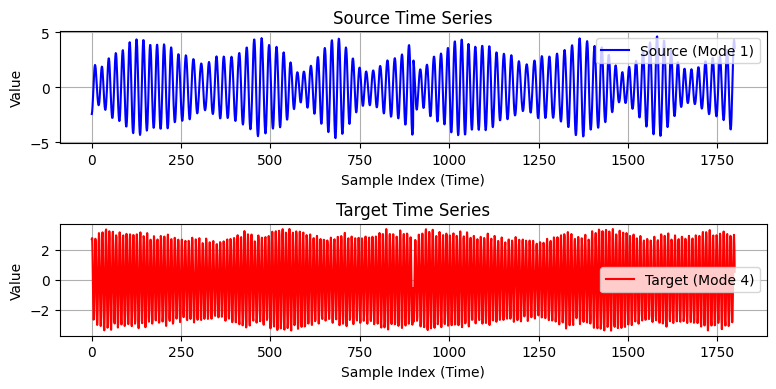

In [ ]:
# time = np.arange(len(s_))

# plt.figure(figsize=(8, 4))

# plt.subplot(2, 1, 1) # source
# plt.plot(time, s_, label=f'Source (Mode {mode_s})', color='blue')
# plt.title('Source Time Series')
# plt.xlabel('Sample Index (Time)')
# plt.ylabel('Value')
# plt.legend()
# plt.grid(True)

# plt.subplot(2, 1, 2) # target
# plt.plot(time, t_, label=f'Target (Mode {mode_t})', color='red')
# plt.title('Target Time Series')
# plt.xlabel('Sample Index (Time)')
# plt.ylabel('Value')
# plt.legend()
# plt.grid(True)

# plt.tight_layout()
# plt.show()

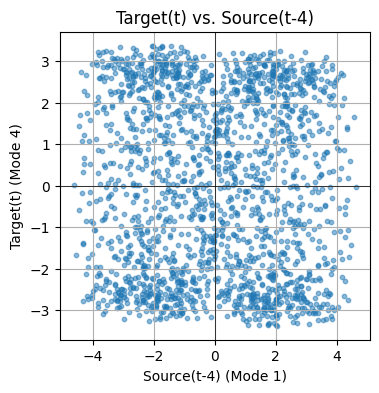

In [ ]:
# # k is the significant lag
# k_source_lag = 4

# source_lagged = s_[:-k_source_lag]
# target_current_for_source_lag = t_[k_source_lag:]

# plt.figure(figsize=(4, 4))
# plt.scatter(source_lagged, target_current_for_source_lag, alpha=0.5, s=10) # s is marker
# plt.title(f'Target(t) vs. Source(t-{k_source_lag})')
# plt.xlabel(f'Source(t-{k_source_lag}) (Mode {mode_s})')
# plt.ylabel(f'Target(t) (Mode {mode_t})')
# plt.grid(True)
# plt.axhline(0, color='black', linewidth=0.5)
# plt.axvline(0, color='black', linewidth=0.5)
# plt.show()
